# **Importing Necessary Library**

In [1]:
import re
import torch
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EvalPrediction

# **Checking GPU Avaibility**

In [2]:
# Check GPU availability
if torch.cuda.is_available():
    print('GPU is available')
else:
    print('No GPU detected')

# Number of available GPUs
num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available")

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

No GPU detected
No GPUs available
Using device: cpu


# **Dataset Path**

In [3]:
df = pd.read_csv('Bangla-Text-Dataset.csv')

# **Dataset Information**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44001 entries, 0 to 44000
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comment               44001 non-null  object 
 1   Category              44001 non-null  object 
 2   Gender                44001 non-null  object 
 3   comment react number  43998 non-null  float64
 4   label                 44001 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.7+ MB


In [5]:
df.head()

,comment,Category,Gender,comment react number,label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Actor,Female,1.0,sexual
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully
4,পটকা মাছ,Politician,Male,0.0,troll


In [6]:
df.tail()

,comment,Category,Gender,comment react number,label
43996,"হিরো আলম,, এগিয়ে যাও",Social,Male,0.0,not bully
43997,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...,Social,Male,1.0,not bully
43998,হিরো ভাই তুমি এগিয়ে য়াও,Social,Male,0.0,not bully
43999,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি,Actor,Female,1.0,not bully
44000,হ্যালো তোমাদের সাথে কি আমাকে চ্যাট করবে,Social,Male,0.0,not bully


In [7]:
df = df[["comment", "label"]]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44001 entries, 0 to 44000
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  44001 non-null  object
 1   label    44001 non-null  object
dtypes: object(2)
memory usage: 687.6+ KB


In [9]:
# Check the label distribution
print("-----Label distribution-----")
print(df['label'].value_counts())

-----Label distribution-----
label
not bully    15340
troll        10462
sexual        8928
religious     7577
threat        1694
Name: count, dtype: int64


# **Dataset Label Distribution Visualize**

C:\Users\Jisan\AppData\Local\Temp\ipykernel_12832\1740153592.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="Set1")


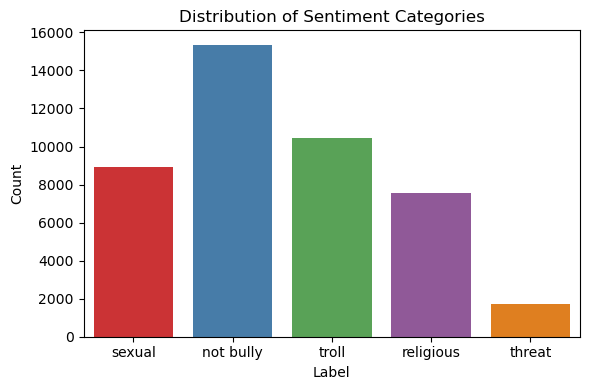

In [10]:
# Visualize the label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette="Set1")
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# **Data Preprocessing**

* Removed url's, emojis, punctuation and speacial characters, extra spaces
* Unicode normalization

In [11]:
# Data Preprocessing
def preprocess_bangla_text(text):
    """
    Preprocess Bangla text by removing special symbols, emojis, URLs, and extra spaces.
    Apply Unicode normalization.
    """
    if not isinstance(text, str):
        return ""
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove emojis (basic implementation)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove special characters (keep Bangla characters and basic punctuation)
    text = re.sub(r'[^\w\s\u0980-\u09FF]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Apply Unicode normalization (NFC for composed characters)
    text = unicodedata.normalize('NFC', text)
    
    return text

In [12]:
# Apply preprocessing
df['processed_text'] = df['comment'].astype(str).apply(preprocess_bangla_text)

In [13]:
df

,comment,label,processed_text
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,sexual,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,not bully,ঘরে বসে শুট করতে কেমন লেগেছে ক্যামেরাতে কে ছিলেন
2,"অরে বাবা, এই টা কোন পাগল????",not bully,অরে বাবা এই টা কোন পাগল
3,ক্যাপ্টেন অফ বাংলাদেশ,not bully,ক্যাপ্টেন অফ বাংলাদেশ
4,পটকা মাছ,troll,পটকা মাছ
...,...,...,...
43996,"হিরো আলম,, এগিয়ে যাও",not bully,হিরো আলম এগিয়ে যাও
43997,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...,not bully,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...
43998,হিরো ভাই তুমি এগিয়ে য়াও,not bully,হিরো ভাই তুমি এগিয়ে য়াও
43999,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি,not bully,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি


# Label Encoding

As we can see that the dataset have 5 labels, we performed multiclass classification

In [14]:
# Encode labels (multiclass)
label_map = {'not bully':0, 'religious':1, 'sexual':2, 'troll':3, 'threat':4}
df['encoded_label'] = df['label'].map(label_map)

In [15]:
df

,comment,label,processed_text,encoded_label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,sexual,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,2
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,not bully,ঘরে বসে শুট করতে কেমন লেগেছে ক্যামেরাতে কে ছিলেন,0
2,"অরে বাবা, এই টা কোন পাগল????",not bully,অরে বাবা এই টা কোন পাগল,0
3,ক্যাপ্টেন অফ বাংলাদেশ,not bully,ক্যাপ্টেন অফ বাংলাদেশ,0
4,পটকা মাছ,troll,পটকা মাছ,3
...,...,...,...,...
43996,"হিরো আলম,, এগিয়ে যাও",not bully,হিরো আলম এগিয়ে যাও,0
43997,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...,not bully,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...,0
43998,হিরো ভাই তুমি এগিয়ে য়াও,not bully,হিরো ভাই তুমি এগিয়ে য়াও,0
43999,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি,not bully,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি,0


# Saving Preprocessed Dataset

In [ ]:
df.to_csv('Bangla-Text-Dataset-Processed.csv', index=False)

# Train-Test Split (80-20 Ratio)

In [16]:
# Train-test split (80/20)
X = df['processed_text']
y = df['encoded_label']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['processed_text'], df['encoded_label'], test_size=0.2, random_state=42, stratify=y)

In [17]:
# ✅ Use a small subset to speed up training (e.g., 100 samples for training, 40 for test)
train_subset_size = 100
test_subset_size = 40

# Use .iloc to slice by index
X_train_raw = X_train_raw.iloc[:train_subset_size]
y_train = y_train.iloc[:train_subset_size]

X_test_raw = X_test_raw.iloc[:test_subset_size]
y_test = y_test.iloc[:test_subset_size]

In [21]:
y_train.value_counts()

encoded_label
0    32
2    25
3    23
1    15
4     5
Name: count, dtype: int64

# **Bangla BERT Pretrained Tokenizer and Model**

In [22]:
# Bangla-BERT fine-tuning
# Tokenizer and model
model_name = 'sagorsarker/bangla-bert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenizing Train-Test

In [23]:
# Create Dataset class
class BanglaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [24]:
# Prepare train and test datasets
train_dataset = BanglaDataset(X_train_raw, y_train, tokenizer)
test_dataset = BanglaDataset(X_test_raw, y_test, tokenizer)

# **Evaluation Matrics**

In [25]:
# Define compute_metrics for evaluation
def compute_metrics(p: EvalPrediction):
    preds = p.predictions.argmax(-1)
    return {
        'accuracy': (preds == p.label_ids).mean(),
        **{
            metric: score
            for metric, score in zip(
                ['precision', 'recall', 'f1'],
                [
                    *precision_recall_fscore_support(p.label_ids, preds, average='weighted')[:3]
                ]
            )
        }
    }

# Hyperparameter Tuning/Fine-tuning Bangla BERT

In [26]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    learning_rate=2e-5,
    weight_decay=0.01
)

In [27]:
# Initialize Trainer with eval_dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# Train model
trainer.train()

C:\Users\Jisan\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.483117,0.350000,0.263462,0.350000,0.294643


C:\Users\Jisan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jisan\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


# **Saving the Model**

In [30]:
# Save the model
trainer.save_model('models')
tokenizer.save_pretrained('models')

('models\\tokenizer_config.json',
 'models\\special_tokens_map.json',
 'models\\vocab.txt',
 'models\\added_tokens.json',
 'models\\tokenizer.json')

# **Model Evaluation**

In [31]:
# Evaluate the model
results = trainer.evaluate()
print(results)

C:\Users\Jisan\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.461822271347046, 'eval_accuracy': 0.325, 'eval_precision': 0.255, 'eval_recall': 0.325, 'eval_f1': 0.243921568627451, 'eval_runtime': 12.2214, 'eval_samples_per_second': 3.273, 'eval_steps_per_second': 0.164, 'epoch': 2.0}


C:\Users\Jisan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
# Evaluation on test set
preds_output = trainer.predict(test_dataset)
preds = preds_output.predictions.argmax(-1)

C:\Users\Jisan\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Jisan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Classification Report**

In [33]:
# Print BERT results
print(classification_report(y_test, preds, target_names=label_map.keys(), digits=5))

              precision    recall  f1-score   support

   not bully    0.39286   0.78571   0.52381        14
   religious    0.00000   0.00000   0.00000        10
      sexual    0.10000   0.14286   0.11765         7
       troll    0.50000   0.12500   0.20000         8
      threat    0.00000   0.00000   0.00000         1

    accuracy                        0.32500        40
   macro avg    0.19857   0.21071   0.16829        40
weighted avg    0.25500   0.32500   0.24392        40



C:\Users\Jisan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jisan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jisan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Confusion Matrix**

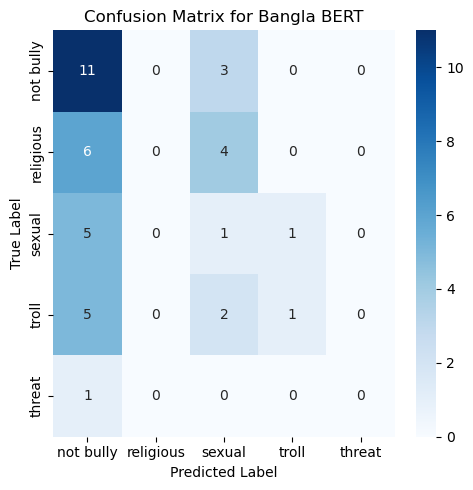

In [35]:
# Display confusion matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Bangla BERT')
plt.tight_layout()
plt.show()

In [36]:
# Export PyTorch model to ONNX
# Move model to CPU for ONNX export
model.eval()
model.cpu()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [39]:
label_map = {'not bully': 0, 'religious': 1, 'sexual': 2, 'troll': 3, 'threat': 4}
id2label = {v: k for k, v in label_map.items()}

In [40]:
def predict_bangla_text(text):
    # Tokenize input text
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    )

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()

    return id2label[predicted_class_id]


In [44]:
text = "ওই হালার পুত এখন কি মদ খাওয়ার সময়"
prediction = predict_bangla_text(text)
print("Predicted label:", prediction)


Predicted label: not bully


In [47]:
from transformers import pipeline
# Load fine-tuned model
model_path = "models"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Hugging Face pipeline
text_clf = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Device set to use cpu
C:\Users\Jisan\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [48]:
import shap

# Use shap.Explainer on the pipeline
explainer = shap.Explainer(text_clf)

# Example Bangla text
text = "তুই একটা বড় ট্রোল"

# Explain the prediction
shap_values = explainer([text])

# Visualize the explanation in Jupyter (optional)
# shap.plots.text(shap_values[0])

PartitionExplainer explainer: 2it [00:21, 21.34s/it]                                                                          


In [55]:
def explain_bangla_text(text):
    preds = text_clf(text)[0]
    top_pred = max(preds, key=lambda x: float(x['score']))
    predicted_class = top_pred['label']
    
    shap_values = explainer([text])
    tokens = shap_values[0].data            # list of tokens
    
    # shap_values[0].values shape: (num_tokens, num_classes)
    # Reduce to a single importance per token by summing absolute values across classes
    import numpy as np
    token_importances = np.abs(shap_values[0].values).sum(axis=1)
    
    # Pair tokens with their importance scores
    token_scores = list(zip(tokens, token_importances))
    token_scores = sorted(token_scores, key=lambda x: x[1], reverse=True)
    total = sum(score for _, score in token_scores)
    
    explained_tokens = []
    for token, score in token_scores[:5]:
        percent = round((score / total) * 100) if total != 0 else 0
        explained_tokens.append(f'"{token}" ({percent}%)')
    
    print(f"• Predicted Class: {predicted_class}")
    print("• Explanation:")
    print(", ".join(explained_tokens))


In [59]:
explain_bangla_text("তুই একটা বড় ট্রোল")

• Predicted Class: LABEL_0
• Explanation:
"বড় " (24%), "োল" (23%), "ট্র" (19%), "একটা " (17%), "ো" (7%)


In [37]:
# Create dummy input for export
dummy_text = "আমি ভালো ছেলে।"
enc = tokenizer(dummy_text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
dummy_input_ids = enc['input_ids']
dummy_attention_mask = enc['attention_mask']

# **Saving the Model into ONNX**

In [38]:
# Export
torch.onnx.export(
    model,                                      # model being run
    (dummy_input_ids, dummy_attention_mask),    # model input (or a tuple for multiple inputs)
    "models/BanglaBERT_ONNX.onnx",            # where to save the model
    input_names=['input_ids', 'attention_mask'],
    output_names=['logits'],
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'sequence'},
        'attention_mask': {0: 'batch_size', 1: 'sequence'},
        'logits': {0: 'batch_size'}
    },
    opset_version=14
)

C:\Users\Jisan\anaconda3\Lib\site-packages\transformers\modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask


OnnxExporterError: Module onnx is not installed!

In [61]:
df.head()

,comment,label,processed_text,encoded_label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,sexual,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,2
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,not bully,ঘরে বসে শুট করতে কেমন লেগেছে ক্যামেরাতে কে ছিলেন,0
2,"অরে বাবা, এই টা কোন পাগল????",not bully,অরে বাবা এই টা কোন পাগল,0
3,ক্যাপ্টেন অফ বাংলাদেশ,not bully,ক্যাপ্টেন অফ বাংলাদেশ,0
4,পটকা মাছ,troll,পটকা মাছ,3


In [66]:
full_text = df.loc[200, 'processed_text']
print(full_text)

আপনি অভিনয় করেন তাই ফ্যান বাচাতে এগুলা বলছেন এখন মুখ দিয়া সত্যিটা বলে ফেসে গেছেন তাই এই কবিতার লাইনটা কারো কাছ থেকে ভাড়া করে আনছেন আপনি একজন নাস্তিক এটাই চরম সত্য unfollowsafakabir
